In [1]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from clean_text import clean_text
from emoji import demojize
import seaborn as sns
sns.set_theme()
import matplotlib.pyplot as plt
import numpy as np
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [2]:
# Load the combined electoral reports dataset
data = pd.read_csv('combined_election_reports.csv', encoding='utf-8')

In [3]:
# Get the shape of the dataframe
print(f"Shape of the df: {data.shape}")

Shape of the df: (128288, 9)


In [82]:
# Filter only labelled data to be used in the classification reports
labelled_data = data[(data['label'] != 'Unstructured')]

In [83]:
labelled_data.shape

(16227, 9)

In [6]:
stoplist = stopwords.words('english')
my_stopwords = "usr url atuser st rd nd th am pm num multiexclamation multiquestion multistop" # my extra stopwords
stoplist = stoplist + my_stopwords.split()
tokenizer = TweetTokenizer()

In [7]:
test_samples = list(data['text'].sample(5))
test_samples

['Wajir Jubilee champions led by gubernatorial candidate Ambassador Mohamed Abdi Mohamud  launch campaigns with show of united force, promise for change; women representative candidate Halima Abdille was in attendance',
 '@ItsMutai Now I can clearly see the team that is sensing defeat. Ghis is what happens when IEBC becomes professional and refuse to be used by the government machinery of the day. Stay put Chebukati. You will be proofen right in due course.',
 'By the way who\'s this "Abdulahi Abdi Mohamed"?\nRaila Odinga\nChebukati\n#Elections2022\nMoses Kuria',
 '@stroneton @IEBCKenya iebc had not banned the manual register. it just said its use was only dependent on failure of electronic register',
 'The Nasa petition: Nasa - Agents in Rift Valley, central ejected from polling stations. #Decision2017… https://t.co/RlsMA1sgoc']

In [8]:
for text in test_samples:
    print(clean_text(text, tokenizer, my_stopwords) + "\n")

wajir jubilee champions led by gubernatorial candidate ambassador mohamed abdi mohamud launch campaigns with show of united force promise for change women representative candidate halima abdille was in attendance

now can clearly see the team that sensing defeat ghis what happens when iebc becomes professional and refuse be used by the government machinery of the day stay put chebukati you will be proofen right in due course

by the way who this abdulahi abdi mohamed raila odinga chebukati elections moses kuria

iebc had not banned the manual register it just said its was only dependent failure of electronic register

the nasa petition nasa agents in rift valley central ejected from polling stations decision



In [9]:
# Apply the clean text function to the tweet column
labelled_data["clean_text"] = labelled_data["text"].apply(lambda text: clean_text(text, tokenizer, my_stopwords))

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/425916389.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["clean_text"] = labelled_data["text"].apply(lambda text: clean_text(text, tokenizer, my_stopwords))


In [10]:
def normalizeToken(token):
    lowercased_token = token.lower()
    if token.startswith("@"):
        return "@USER"
    elif lowercased_token.startswith("http") or lowercased_token.startswith("www"):
        return "HTTPURL"
    elif len(token) == 1:
        return demojize(token)
    else:
        if token == "’":
            return "'"
        elif token == "…":
            return "..."
        else:
            return token

def normalizeTweet(tweet):
    tokens = tokenizer.tokenize(tweet.replace("’", "'").replace("…", "..."))
    normTweet = " ".join([normalizeToken(token) for token in tokens])
    normTweet = (
        normTweet.replace("cannot ", "can not ")
        .replace("n't ", " n't ")
        .replace("n 't ", " n't ")
        .replace("ca n't", "can't")
        .replace("ai n't", "ain't")
    )
    normTweet = (
        normTweet.replace("'m ", " 'm ")
        .replace("'re ", " 're ")
        .replace("'s ", " 's ")
        .replace("'ll ", " 'll ")
        .replace("'d ", " 'd ")
        .replace("'ve ", " 've ")
    )
    normTweet = (
        normTweet.replace(" p . m .", "  p.m.")
        .replace(" p . m ", " p.m ")
        .replace(" a . m .", " a.m.")
        .replace(" a . m ", " a.m ")
    )
    return " ".join(normTweet.split())

In [11]:
for ts in test_samples:
    print(normalizeTweet(ts) + "\n")

Wajir Jubilee champions led by gubernatorial candidate Ambassador Mohamed Abdi Mohamud launch campaigns with show of united force , promise for change ; women representative candidate Halima Abdille was in attendance

@USER Now I can clearly see the team that is sensing defeat . Ghis is what happens when IEBC becomes professional and refuse to be used by the government machinery of the day . Stay put Chebukati . You will be proofen right in due course .

By the way who 's this " Abdulahi Abdi Mohamed " ? Raila Odinga Chebukati #Elections2022 Moses Kuria

@USER @USER iebc had not banned the manual register . it just said its use was only dependent on failure of electronic register

The Nasa petition : Nasa - Agents in Rift Valley , central ejected from polling stations . #Decision2017 ... HTTPURL



In [12]:
# Apply the normalize text function to the tweet column
labelled_data["normalized_text"] = labelled_data["text"].map(normalizeTweet)

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/1810873632.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data["normalized_text"] = labelled_data["text"].map(normalizeTweet)


In [13]:
labelled_data["normalized_text"].head()

0                                              HTTPURL
1                                              HTTPURL
2    Elections are coming . Youths should turn up ,...
3    It is important for youths to understand the e...
5    Voting is just one of the many ways young peop...
Name: normalized_text, dtype: object

In [14]:
# Before assigning model data, check the number of tokens in each report as done in the baseline approach
labelled_data['word_count'] = labelled_data['normalized_text'].apply(lambda x: len(tokenizer.tokenize(x)))

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/1327255698.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labelled_data['word_count'] = labelled_data['normalized_text'].apply(lambda x: len(tokenizer.tokenize(x)))


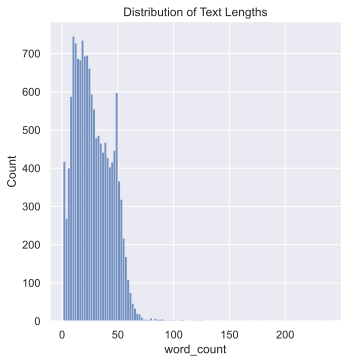

In [15]:
# Visualise word count distribution
sns.displot(labelled_data, x="word_count")
plt.title('Distribution of Text Lengths')
plt.show()

In [16]:
labelled_data['word_count'].describe()

count    14524.000000
mean        28.002066
std         16.591063
min          1.000000
25%         15.000000
50%         25.000000
75%         40.000000
max        238.000000
Name: word_count, dtype: float64

In [17]:
# Analyse the proportion of data that has less than 5 tokens after cleaning the data - similar to the BERT example for checking
lengths_en = labelled_data['word_count'].to_numpy()

min_len = 3

# Count the number of sequences that are longer than `max_len` tokens.
num_truncated = np.sum(np.less(lengths_en, min_len))

# Compare this to the total number of training sentences.
num_sentences = len(lengths_en)
prcnt = float(num_truncated) / float(num_sentences)

print('{:,} of {:,} sentences ({:.1%}) in the training set are shorter than {:} tokens.'.format(num_truncated, num_sentences, prcnt, min_len))

343 of 14,524 sentences (2.4%) in the training set are shorter than 3 tokens.


In [18]:
# Look at a sample of the sentences that are less than 3
labelled_data[labelled_data['word_count'] == 3].sample(10)

,id,label,text,status,date,categories,latitude,longitude,Election Date,clean_text,normalized_text,word_count
86652,4289.0,Positive Events,Everything ok#Cherenganyi,archived,2017-08-08 07:16:58,NaN,-1.832725,38.000411,August 2017,everything okcherenganyi,Everything ok #Cherenganyi,3
1681,76284.0,Opinions,#kenyaelections2022 \n#KenyaDecides \n#KenyaDe...,archived,2022-08-15 12:01:58,Positive Opinions,-1.292066,36.821946,August 2022,kenyaelections kenyadecides kenyadecides,#kenyaelections2022 #KenyaDecides #KenyaDecide...,3
1048,63673.0,Opinions,sawa iebc chairman,published,2022-08-12 20:39:35,Personal Opinion,-1.292066,36.821946,August 2022,sawa iebc chairman,sawa iebc chairman,3
91007,9650.0,Other,Election was good,published,2017-08-10 11:01:10,NaN,-0.291363,36.118226,August 2017,election was good,Election was good,3
7308,19784.0,Positive Events,let peace win,archived,2022-07-26 11:37:24,NaN,NaN,NaN,August 2022,let peace win,let peace win,3
8744,22783.0,Opinions,#chebukati ameingia line,published,2022-07-28 13:08:26,Personal Opinion,-1.319959,36.792890,August 2022,chebukati ameingia line,#chebukati ameingia line,3
85471,2480.0,Positive Events,Presence of security,draft,2017-08-08 03:23:43,NaN,-1.054270,34.487396,August 2017,presence of security,Presence of security,3
125494,35725.0,Counting and Results,Compilation still continueing,published,2017-10-27 06:53:32,Provisional Citizen Results,-1.655043,37.333831,October 2017,compilation still continueing,Compilation still continueing,3
10622,28642.0,Opinions,Political liars!,archived,2022-08-02 17:54:33,Neutral,-1.396499,37.220812,August 2022,political liars,Political liars !,3
10827,30150.0,Opinions,#votepeacebeforepresident #KenyaDecides #Trending,archived,2022-08-03 09:57:32,Peace messages,-1.375142,36.890114,August 2022,votepeacebeforepresident kenyadecides trending,#votepeacebeforepresident #KenyaDecides #Trending,3


In [19]:
# Drop all instances of text that are less than 3 tokens as they may not provide any useful information
# Drop rows where any column has a value less than the threshold
labelled_data = labelled_data.drop(labelled_data[labelled_data['word_count'] < min_len].index)

In [20]:
labelled_data.shape

(14181, 12)

In [21]:
# Merge labels in the dataset
labelled_data["merged_label"] = labelled_data['label'].replace({'Polling Station Administration':"Voting Issues",'Staffing Issues':"Voting Issues", "Voting Issues":"Voting Issues", "Opinions":"Other"})

In [22]:
labelled_data['merged_label'].unique()

array(['Other', 'Political Rallies', 'Positive Events', 'Security Issues',
       'Voting Issues', 'Counting and Results'], dtype=object)

In [23]:
# Create informative vs non-informative features
labelled_data["informative_label"] = labelled_data['label'].replace({'Polling Station Administration':'Informative', 'Staffing Issues':'Informative',
                                                                      'Voting Issues':"Informative",'Political Rallies':"Informative",
                                                                     "Positive Events":"Informative", "Other":"Non-Informative", 'Opinions':'Non-Informative',
                                                                     'Media Reports':'Informative', "Counting and Results":"Informative", "Security Issues":"Informative"})

In [24]:
# Calculate remaining features - temporal information
# Include temporal information i.e.; number of days after election and possibly time of the day
election_days_dict = {
    'August 2022': pd.to_datetime('2022-08-09'), # Retrieved from - https://en.wikipedia.org/wiki/2022_Kenyan_general_election
    'August 2017': pd.to_datetime('2017-08-09'), # Retrieved from - https://en.wikipedia.org/wiki/2017_Kenyan_general_election
    'October 2017': pd.to_datetime('2017-10-26') # Retrieved from - https://en.wikipedia.org/wiki/October_2017_Kenyan_presidential_election
}

In [25]:
def calculate_distance_from_election(election_label,report_date):
  """
  Calculates the distance in days between a given election label and a report date.

    Args:
        election_label (str): The label of the election.
        report_date (datetime.date): The date of the report.

    Returns:
        int: The absolute distance in days between the election and the report date.
    """
  distance = election_days_dict[election_label] - report_date
  return distance.days

In [26]:
model_data = labelled_data[['text', 'clean_text','normalized_text','merged_label', 'label', 'status', 'Election Date','date','informative_label']]

In [27]:
model_data['date'] = pd.to_datetime(model_data['date'])

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/771509874.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['date'] = pd.to_datetime(model_data['date'])


In [28]:
model_data['election_distance'] = model_data.apply(lambda row: calculate_distance_from_election(row['Election Date'], row['date']), axis=1)

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/840337595.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['election_distance'] = model_data.apply(lambda row: calculate_distance_from_election(row['Election Date'], row['date']), axis=1)


In [29]:
model_data['election_distance_abs'] = model_data['election_distance'].map(abs)

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/3573771975.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['election_distance_abs'] = model_data['election_distance'].map(abs)


In [30]:
model_data['hour'] = model_data['date'].dt.hour
model_data['hour_sin'] = np.sin(2 * np.pi * model_data['hour'] / 24)
model_data['hour_cos'] = np.cos(2 * np.pi * model_data['hour'] / 24)

/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/1663548917.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['hour'] = model_data['date'].dt.hour
/var/folders/pz/qy3yq1t97s7g1m5s3hbsqjpc0000gn/T/ipykernel_36034/1663548917.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_data['hour_sin'] = np.sin(2 * np.pi * model_data['hour'] / 24)


In [31]:
# Split the model data into train, test and validation 
import random

In [54]:
model_data.shape

(14181, 14)

In [32]:
# First, calculate the split sizes. 80% training, 10% validation, 10% test.
train_size = int(0.8 * len(model_data))
val_size = int(0.1 * len(model_data))
test_size = len(model_data) - (train_size + val_size)

In [33]:
# Sanity check the sizes.
assert((train_size + val_size + test_size) == len(model_data))

In [34]:
# Create a list of indeces for all of the samples in the dataset.
indeces = np.arange(0, len(model_data))

In [35]:
# Shuffle the indeces randomly.
random.shuffle(indeces)

# Get a list of indeces for each of the splits.
train_idx = indeces[0:train_size]
val_idx = indeces[train_size:(train_size + val_size)]
test_idx = indeces[(train_size + val_size):]

# Sanity check
assert(len(train_idx) == train_size)
assert(len(test_idx) == test_size)

# With these lists, we can now select the corresponding dataframe rows using, 
# e.g., train_df = data_df.iloc[train_idx] 

print('  Training size: {:,}'.format(train_size))
print('Validation size: {:,}'.format(val_size))
print('      Test size: {:,}'.format(test_size))

  Training size: 11,344
Validation size: 1,418
      Test size: 1,419


In [36]:
train_data = model_data.iloc[train_idx]
val_data = model_data.iloc[val_idx]
test_data = model_data.iloc[test_idx]

In [55]:
model_data.head()

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,election_distance_abs,hour,hour_sin,hour_cos
2,"Elections are coming. Youths should turn up,vo...",elections are coming youths should turn up vot...,"Elections are coming . Youths should turn up ,...",Other,Opinions,published,August 2022,2022-07-05 05:08:29,Non-Informative,34,34,5,0.965926,0.258819
3,It is important for youths to understand the e...,it important for youths understand the electio...,It is important for youths to understand the e...,Other,Opinions,published,August 2022,2022-07-05 05:16:28,Non-Informative,34,34,5,0.965926,0.258819
5,Voting is just one of the many ways young peop...,voting just one of the many ways young people ...,Voting is just one of the many ways young peop...,Other,Opinions,published,August 2022,2022-07-05 07:19:47,Non-Informative,34,34,7,0.965926,-0.258819
6,Let's all stand out as youth to be agents of c...,let all stand out as youth be agents of change...,Let 's all stand out as youth to be agents of ...,Other,Opinions,published,August 2022,2022-07-05 07:15:02,Non-Informative,34,34,7,0.965926,-0.258819
8,Quite critical indeed @ItsKimaniThomas\nThe ac...,quite critical indeed the active and meaningfu...,Quite critical indeed @USER The active and mea...,Other,Opinions,published,August 2022,2022-07-05 08:47:59,Non-Informative,34,34,8,0.866025,-0.500000


In [57]:
from sklearn.model_selection import train_test_split

# Perform train-test split (70% train, 30% test)
train_data, test_data = train_test_split(
    model_data,  # Assuming 'text' column contains the input data
    test_size=0.3,
    random_state=42,
    stratify=model_data['merged_label']  # Perform stratified sampling based on labels
)

# Perform further split on the test set to create validation set (10% validation, 20% test)
test_data, val_data = train_test_split(
    test_data,
    test_size=0.33,  # 10% of the test set (0.33 * 0.3 = 0.099 ≈ 10%)
    random_state=42,
    stratify=test_data['merged_label']  # Perform stratified sampling based on labels
)

# Print the sizes of each split
print("Train set size:", len(train_data))
print("Validation set size:", len(val_data))
print("Test set size:", len(test_data))


Train set size: 9926
Validation set size: 1405
Test set size: 2850


In [58]:
print(f'  Training size: {train_data.shape}')
print(f'Validation size: {val_data.shape}')
print(f'      Test size: {test_data.shape}')

  Training size: (9926, 14)
Validation size: (1405, 14)
      Test size: (2850, 14)


In [75]:
# Check the label distribution across the datasets to ensure imbalances are represented across all datasets

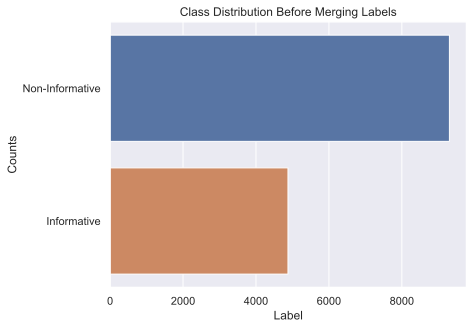

In [60]:
grouped_counts = labelled_data.groupby("informative_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='informative_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

In [76]:
# Validate the election year dataset grouping is balanced across the datasets

In [77]:
labelled_data.columns

Index(['id', 'label', 'text', 'status', 'date', 'categories', 'latitude',
       'longitude', 'Election Date', 'clean_text', 'normalized_text',
       'word_count', 'merged_label', 'informative_label'],
      dtype='object')

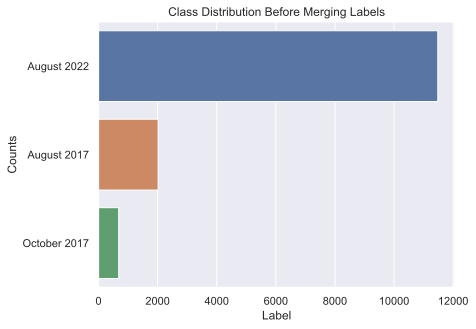

In [78]:
grouped_counts = labelled_data.groupby("Election Date").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='Election Date')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

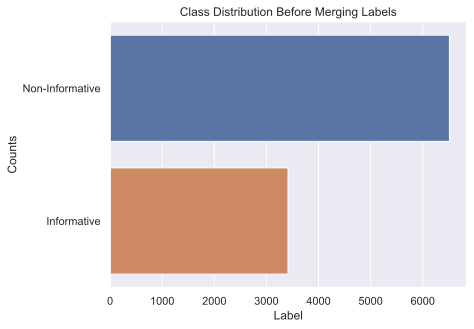

In [61]:
# Train Data
grouped_counts = train_data.groupby("informative_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='informative_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

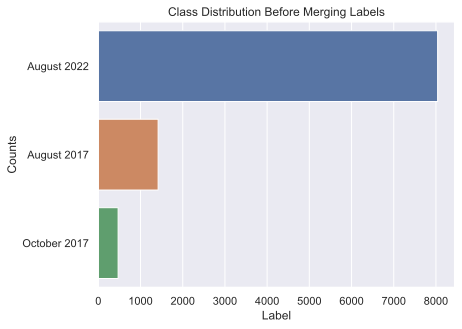

In [79]:
# Train Data
grouped_counts = train_data.groupby("Election Date").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y="Election Date")
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

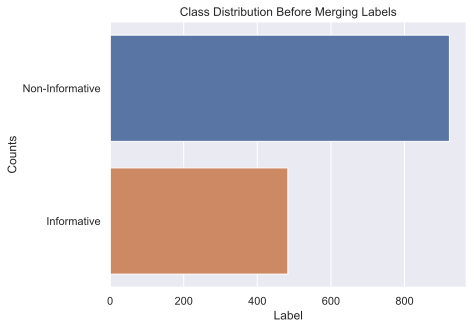

In [62]:
# Validation Data
grouped_counts = val_data.groupby("informative_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='informative_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

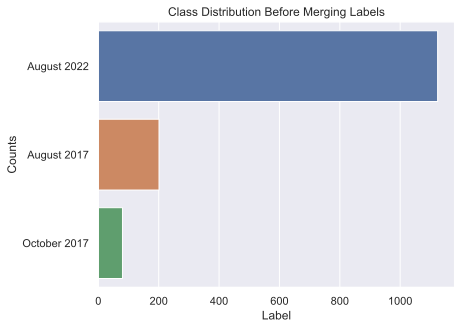

In [80]:
# Val Data
grouped_counts = val_data.groupby("Election Date").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y="Election Date")
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

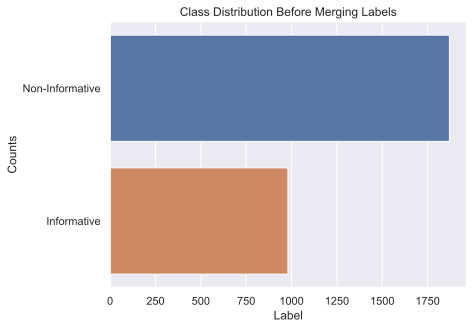

In [63]:
# Test Data
grouped_counts = test_data.groupby("informative_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='informative_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

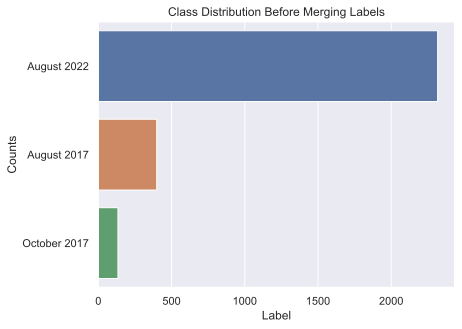

In [81]:
# Test Data
grouped_counts = test_data.groupby("Election Date").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y="Election Date")
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

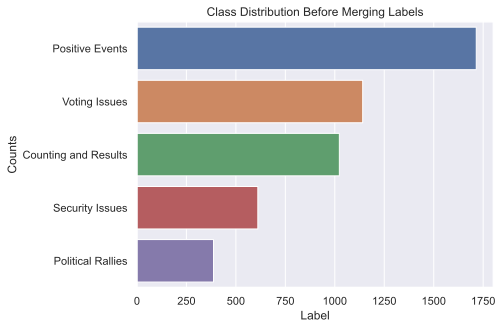

In [64]:
# Check the distribution of the informative types on the datasets 
informative_data = labelled_data[labelled_data['informative_label'] == 'Informative']
grouped_counts = informative_data.groupby("merged_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='merged_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

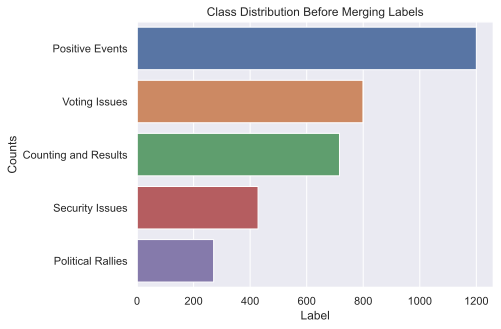

In [65]:
# Check the distribution of the informative types on the datasets 
informative_train_data = train_data[train_data['informative_label'] == 'Informative']
grouped_counts = informative_train_data.groupby("merged_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='merged_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

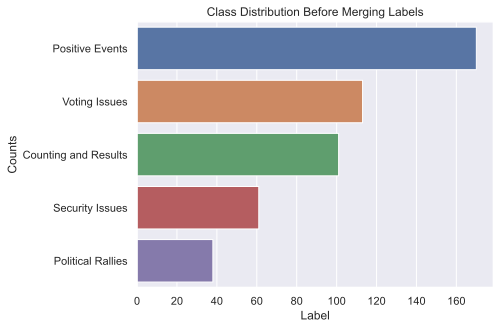

In [66]:
# Check the distribution of the informative types on the datasets 
informative_val_data = val_data[val_data['informative_label'] == 'Informative']
grouped_counts = informative_val_data.groupby("merged_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='merged_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

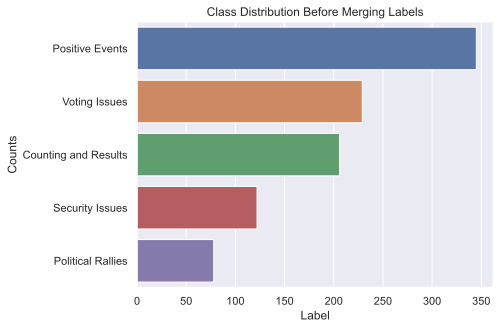

In [67]:
# Check the distribution of the informative types on the datasets 
informative_test_data = test_data[test_data['informative_label'] == 'Informative']
grouped_counts = informative_test_data.groupby("merged_label").size().reset_index(name='Counts').sort_values(["Counts"], ascending=False)
sns.barplot(data=grouped_counts, x='Counts', y='merged_label')
plt.xlabel('Label')
plt.ylabel('Counts')
plt.title('Class Distribution Before Merging Labels')
plt.show()

In [68]:
print(f'  Training size: {informative_train_data.shape}')
print(f'Validation size: {informative_val_data.shape}')
print(f'      Test size: {informative_test_data.shape}')

  Training size: (3414, 14)
Validation size: (483, 14)
      Test size: (980, 14)


In [69]:
import csv

In [70]:
# Save the datasets into a csv's 
model_data.to_csv("labelled_election_reports.csv",  quoting=csv.QUOTE_NONNUMERIC, index=False)

In [71]:
train_data.to_csv("train_election_reports.csv", quoting=csv.QUOTE_NONNUMERIC, index=False)

In [72]:
test_data.to_csv('test_election_reports.csv', quoting=csv.QUOTE_NONNUMERIC, index=False)

In [73]:
val_data.to_csv('val_election_reports.csv', quoting=csv.QUOTE_NONNUMERIC, index=False)

In [74]:
train_data.head()

,text,clean_text,normalized_text,merged_label,label,status,Election Date,date,informative_label,election_distance,election_distance_abs,hour,hour_sin,hour_cos
88059,Presiding officer captured all rejected ballot...,presiding officer captured all rejected ballot...,Presiding officer captured all rejected ballot...,Positive Events,Positive Events,draft,August 2017,2017-08-08 15:40:15,Informative,0,0,15,-7.071068e-01,-0.707107
12517,MP seat elections of a particular constituency...,mp seat elections of particular constituency i...,MP seat elections of a particular constituency...,Other,Opinions,published,August 2022,2022-08-09 05:12:56,Non-Informative,-1,1,5,9.659258e-01,0.258819
87121,Political Party agents acting in hostile manner,political party agents acting in hostile manner,Political Party agents acting in hostile manner,Security Issues,Security Issues,published,August 2017,2017-08-08 09:39:37,Informative,0,0,9,7.071068e-01,-0.707107
4565,UTARATIBU WA KUPIGA KURA #GE2022\nYour vote is...,utaratibu wa kupiga kura ge your vote your voi...,UTARATIBU WA KUPIGA KURA #GE2022 Your vote is ...,Positive Events,Positive Events,published,August 2022,2022-07-21 12:02:45,Informative,18,18,12,1.224647e-16,-1.000000
807,"@KiamaKaara in abundance of caution, let the f...",in abundance of caution let the former governo...,"@USER in abundance of caution , let the former...",Other,Opinions,published,August 2022,2022-08-12 12:09:57,Non-Informative,-4,4,12,1.224647e-16,-1.000000
